This notebook is to show the application of our method to three datasets. Two of them are simulated and one is from real experiments. The results are included in the manuscript. This notebook is also an example to show the usage of the code.

In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport graph
%aimport hyper
%aimport vlgp

In [8]:
from os import path, getcwd, makedirs
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, graph, hyper, vlgp
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

In [45]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
c0 = list(mpl.rcParams['axes.prop_cycle'])[0]['color']
c1 = list(mpl.rcParams['axes.prop_cycle'])[1]['color']
c2 = list(mpl.rcParams['axes.prop_cycle'])[2]['color']

The following code creates the directories in the current working directory if they do not exist. The directory 'sample' contains the data to be analyzed, 'output' stores the fit and prediction, and the generated plots are put in 'figure'.

In [16]:
if not path.exists('sample'):
    makedirs('sample')
if not path.exists('output'):
    makedirs('output')
if not path.exists('figure'):
    makedirs('figure')
samplepath = path.abspath('sample')
outputpath = path.abspath('output')
figurepath = path.abspath('figure')

# Lorenz latent

In this section we apply the model to the samples of spike trains driven by Lorenz dynamics. We totally simulate 5 samples. Each sample consists of spike trians of 50 neurons over 1000ms which are driven by a 3-dimensional latent dynamics. 

In [17]:
# dimensions
nsample = 5
ntrial = 10
ntime = 1000
nspike = 50
nlatent = 3

The Lorenz dynamics is defined by the following differential equations.
\begin{align} 
      x_1' &= \sigma(x_2 - x_1) \\
      x_2' &= x_1(\rho - x_3) - x_2 \\
      x_3' &= x_1 x_2 - \beta x_3
\end{align}
The discrete latent dynamics are sampled with the time step of 0.0015. We discard the first 2000 points to get stable result.

In [18]:
# Lorenz
np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip + nsample * ntrial * ntime, dt=1.5e-3, x0=np.random.random(3) * 2)
lorenz = (lorenz - lorenz.mean(axis=0)) / norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((nsample, ntrial, ntime, -1))

The spike trains are simulated with 10ms history filter given the above latent. The elements of loading matrix is randomly generated from (1, 2) with random signs. The history filter decays in time. The bias of firing rate is 15Hz.

In [22]:
np.random.seed(0)
low = np.log(15 / ntime)
aspk = np.sort((np.random.rand(nlatent, nspike) + 1) * np.sign(np.random.randn(nlatent, nspike)), axis=1)
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike), 
                  -3 * np.ones(nspike), -3 * np.ones(nspike), -3 * np.ones(nspike), -2 * np.ones(nspike),
                  -2 * np.ones(nspike), -1 * np.ones(nspike), -1 * np.ones(nspike)))

y = np.empty((nsample, ntrial, ntime, nspike))  # spike trains
rate = np.empty_like(y, dtype=float)  # firing rates
lorenz = [] # Lorenz samples
florenz = [] # filenames of Lorenz samples
for i in range(nsample):
    y[i, :], _, rate[i, :] = simulation.spike(x[i, :], aspk, bspk)
    # print('mean firing rate per neuron', y.mean(axis=(0, 1)) * 1000)
    lorenz.append({'y': y[i, :], 'rate': rate[i, :], 'x': x[i, :], 'alpha': aspk, 'beta':bspk})
    fname = path.join(samplepath, 'lorenz_{}'.format(i + 1))
    florenz.append(fname)
    savemat(fname, lorenz[i])

Load the simulation and fit models. 

In [23]:
florenz = [path.join(samplepath, 'lorenz_{}'.format(i + 1)) for i in range(nsample)]
for i, fname in enumerate(florenz):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    sample = loadmat(fname, squeeze_me=True)
    result = vlgp.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
                                   alpha=sample['alpha'], beta=sample['beta'], lag=10, rank=100, 
                                   niter=100, tol=1e-5, verbose=False, learn_omega=True)
    savemat(path.join(outputpath, '{}_vLGP'.format(path.basename(fname))), result)
print('Done.')

Load results. The fits of PLDS and GPFA should be put in the output path before loading.

In [36]:
# Collect results
lorenz_vLGP = []
for i, fname in enumerate(florenz):
    lorenz_vLGP.append(loadmat(path.join(outputpath, '{}_vLGP'.format(path.basename(fname))), squeeze_me=True))
    
lorenz_GPFA = []
for i, fname in enumerate(florenz):
    lorenz_GPFA.append(loadmat(path.join(outputpath, '{}_GPFA'.format(path.basename(fname))), squeeze_me=True))

lorenz_PLDS = []
for i, fname in enumerate(florenz):
    lorenz_PLDS.append(loadmat(path.join(outputpath, '{}_PLDS'.format(path.basename(fname))), squeeze_me=True))

Angle between subspaces of latent vs time

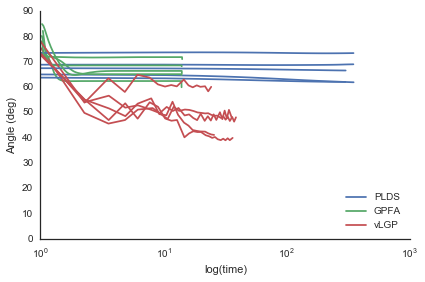

In [47]:
sns.set_style("white")
for i in range(nsample):
    lorenz_PLDS[i]['Time'][0] = 1
    lorenz_GPFA[i]['iterTime'][0] = 1
    lorenz_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(lorenz_PLDS[i]['Time']), rad2deg(lorenz_PLDS[i]['latentAngle'][1:]), color=c0);
    plt.semilogx(np.cumsum(lorenz_GPFA[i]['iterTime']), rad2deg(lorenz_GPFA[i]['latentAngle']), color=c1);
    plt.semilogx(np.cumsum(lorenz_vLGP[i]['Elapsed'][:,2]), rad2deg(lorenz_vLGP[i]['LatentAngle']), color=c2);
plt.xlabel('log(time)');
plt.ylabel('Angle (deg)');
sns.despine(top=True, right=True)
# plt.title('Subspace angle of the latent dynamics');
plt.ylim([0, 90]);
PLDSline = Line2D((0, 0), (1, 1), color=c0);
GPFAline = Line2D((0, 0), (1, 1), color=c1);
vLGPline = Line2D((0, 0), (1, 1), color=c2);
plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'vLGP'], loc='lower right');
plt.tight_layout()

# for i in range(nsample):
#     lorenz_PLDS[i]['Time'][0] = 1
#     lorenz_GPFA[i]['iterTime'][0] = 1
#     lorenz_vLGP[i]['Elapsed'][0, :] = 1
#     plt.semilogx(np.cumsum(lorenz_PLDS[i]['Time']), rad2deg(lorenz_PLDS[i]['loadingAngle']), color=c0);
#     plt.semilogx(np.cumsum(lorenz_GPFA[i]['iterTime']), rad2deg(lorenz_GPFA[i]['loadingAngle']), color=c1);
#     plt.semilogx(np.cumsum(lorenz_vLGP[i]['Elapsed'][:,2]), rad2deg(lorenz_vLGP[i]['LoadingAngle']), color=c2);
# plt.xlabel('log(time)');
# plt.ylabel('angle');
# plt.title('Subspace angle of the loading matrix');
# plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'Proposed'], bbox_to_anchor=(1.1, -0.1));

We use a leave-one-neuron-out prediction likelihood to compare models.
We choose one of the trials as test trial and the others as training trials.
First, the weights and posterior are inferred from the training trials.
Next, we leave one neuron out of the test trial and make inference on the posterior of the test trial given the rest neurons and the weights estimated from the training trials.
Then the firing rates of the very neuron are predicted by the model given the weights from the training trials and the posterior inferred from the rest of neurons in the test trial.
We do this procedure on each neuron of one trial and each trial of the sample.
Finally we obtain the prediction of all neurons at all time bins of the sample.

In [ ]:
# CV
for i, fname in enumerate(florenz):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = Lorenz_vLGP[i]['omega']
    sample = loadmat(fname, squeeze_me=True)
    result = vlgp.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, lag=10, rank=100, 
                                   niter=100, tol=1e-5, learn_omega=True)
    savemat(path.join(outputpath, '{}_vLGP_pred'.format(path.basename(fname))), result)
print('Done.')

In [48]:
# load CV prediction
lorenz_vLGP_cv = [loadmat('{}/lorenz_{}_vLGP_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
lorenz_PLDS_cv = [loadmat('{}/lorenz_{}_PLDS_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
lorenz_GPFA_cv = [loadmat('{}/lorenz_{}_GPFA_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]

In [49]:
# Log-likelihood
LL = np.zeros((nsample, ntrial, 3))
y = np.zeros((nsample, ntrial, ntime, nspike), dtype=float)
for i in range(nsample):
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(lorenz_vLGP_cv[i]['y'], lorenz_vLGP_cv[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(lorenz_vLGP_cv[i]['y'], lorenz_GPFA_cv[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(lorenz_vLGP_cv[i]['y'], lorenz_PLDS_cv[i]['yhat']), axis=(1, 2))
    y[i, :] = lorenz_vLGP_cv[i]['y']
nullyhat = np.repeat(y.mean(axis=2), ntime, axis=2).reshape((nsample, ntrial, ntime, nspike))
nullLL = np.nansum(stats.poisson.logpmf(y, nullyhat), axis=(2, 3))

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


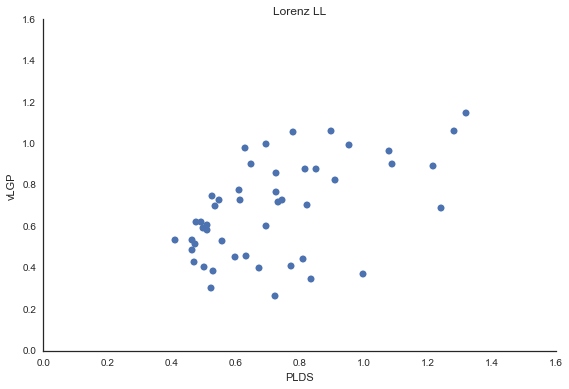

In [50]:
plt.plot((LL[:, :, 0].ravel() - nullLL.ravel()) / ntime / np.log(2), (LL[:, :, 2].ravel() - nullLL.ravel()) / ntime / np.log(2), ls='', marker='o');
sns.despine(right=True, top=True)
# plt.axes().set_aspect('equal', 'datalim');
plt.xlabel('PLDS');
plt.ylabel('vLGP');
plt.xlim([0, 1.6]);
plt.ylim([0, 1.6]);
plt.title('Lorenz LL');
# plt.legend(loc='upper right');
plt.tight_layout();

# LDS latent

The second dataset uses 3-dimensional linear dynamical system as log firing rate. The system is defined as
\begin{align}
    y_{t,n} \mid \mathbf{x}_t &\sim Poisson(\ln(1 + \exp(\mathbf{c}_n^\top \mathbf{x}_t + \mathbf{d}_n)) \\
    \mathbf{x}_0 &\sim \mathcal{N}(\boldsymbol{\mu}_0, Q_0) \\
    \mathbf{x}_{t+1} \mid \mathbf{x}_t &\sim \mathcal{N}(A \mathbf{x}_t + \mathbf{b}_t, Q)
\end{align}

In [ ]:
# dimensions
nsample = 5
ntrial = 10
ntime = 1000
nspike = 50
nlatent = 3

In [ ]:
# load sample
fplds = ['{}/PLDS_{}'.format(samplepath, i + 1) for i in range(nsample)]
PLDSSample = []
for i, fname in enumerate(fPLDSSample):
    mat = loadmat(fname, squeeze_me=True)
    PLDSSample.append(mat)

In [ ]:
# fit
for i, sample in enumerate(PLDSSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    result = vlgp.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
                                   alpha=sample['alpha'], beta=sample['beta'], lag=0, rank=100, 
                                   niter=100, tol=1e-5, verbose=False, learn_omega=True)
    savemat('{}/PLDS_{}_vLGP'.format(outputpath, i + 1), result)
print('Done.')

In [ ]:
# angle
for i in range(nsample):
    PLDS_PLDS[i]['Time'][0] = 1
    PLDS_GPFA[i]['iterTime'][0] = 1
    PLDS_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(PLDS_PLDS[i]['Time']), rad2deg(PLDS_PLDS[i]['latentAngle']), color=c0);
    plt.semilogx(np.cumsum(PLDS_GPFA[i]['iterTime']), rad2deg(PLDS_GPFA[i]['latentAngle']), color=c1);
    plt.semilogx(np.cumsum(PLDS_vLGP[i]['Elapsed'][:,2]), rad2deg(PLDS_vLGP[i]['LatentAngle']), color=c2);
plt.xlabel('log(time)');
plt.ylabel('Angle (deg)');
sns.despine(top=True, right=True)
# plt.title('Subspace angle of the latent dynamics');
plt.ylim([0, 90]);
PLDSline = Line2D((0, 0), (1, 1), color=c0);
GPFAline = Line2D((0, 0), (1, 1), color=c1);
vLGPline = Line2D((0, 0), (1, 1), color=c2);
plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'vLGP'], loc='lower right', bbox_to_anchor=(1.05, -0.1));
plt.tight_layout()


In [ ]:
# cv
for i, sample in enumerate(PLDSSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = PLDS_vLGP[i]['omega']
    result = vlgp.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, lag=0, rank=100, 
                                   niter=100, tol=1e-5, learn_omega=True)
    savemat('{}/PLDS_{}_vLGP_pred'.format(outputpath, i + 1), result)
print('Done.')

In [ ]:
PLDSCV_vLGP = [loadmat('{}/PLDS_{}_vLGP_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
PLDSCV_PLDS = [loadmat('{}/PLDS_{}_PLDS_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
PLDSCV_GPFA = [loadmat('{}/PLDS_{}_GPFA_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]

In [ ]:
LL = np.zeros((nsample, ntrial, 3))

for i in range(5):
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_PLDS[i]['yhat']), axis=(1, 2))
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_vLGP[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_GPFA[i]['yhat']**2), axis=(1, 2))

In [ ]:
LL = np.zeros((nsample, ntrial, 3))
y = np.zeros((nsample, ntrial, ntime, nspike), dtype=float)
for i in range(nsample):
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_vLGP[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_GPFA[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_PLDS[i]['yhat']), axis=(1, 2))
    y[i, :] = PLDSCV_vLGP[i]['y']
nullyhat = np.repeat(y.mean(axis=2), ntime, axis=2).reshape((nsample, ntrial, ntime, nspike))
nullLL = np.nansum(stats.poisson.logpmf(y, nullyhat), axis=(2, 3))
plt.figure(figsize=(4, 3));
for i in range(nsample):
    plt.plot(np.arange(ntrial) + 1, (LL[i, :, 0] - nullLL[i, :]) / ntime / np.log(2), ls='', marker='o', color=c0, label='PLDS');
    plt.plot(np.arange(ntrial) + 1, (LL[i, :, 1] - nullLL[i, :]) / ntime / np.log(2), ls='', marker='o', color=c1, label='GPFA');
    plt.plot(np.arange(ntrial) + 1, (LL[i, :, 2] - nullLL[i, :]) / ntime / np.log(2), ls='', marker='o', color=c2, label='vLGP');
sns.despine(right=True, top=True)
plt.xlim([0, 11]);
plt.xlabel('Trial');
plt.title('PLDS LL');
# plt.legend(loc='upper right');
plt.tight_layout();


In [ ]:
plt.plot((LL[:, :, 0].ravel() - nullLL.ravel()) / ntime / np.log(2), (LL[:, :, 2].ravel() - nullLL.ravel()) / ntime / np.log(2), ls='', marker='o');
sns.despine(right=True, top=True)
# plt.axes().set_aspect('equal', 'datalim');
plt.xlabel('PLDS');
plt.ylabel('vLGP');
plt.xlim([0, 3]);
plt.ylim([0, 3]);
plt.title('PLDS LL');
# plt.legend(loc='upper right');
plt.tight_layout();

# Graf's data

In [51]:
graf = loadmat(path.join(samplepath, 'Graf'), squeeze_me=True)